In [144]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [145]:
suites = ["number_src"]

## Prediction results

In [146]:
prediction_dfs = [pd.read_csv(f"{suite}.predictions.csv") for suite in suites]
prediction_df = pd.concat(prediction_dfs, names=["suite"], keys=suites)
prediction_df["first_item"] = prediction_df.used_item_numbers.str.split().str.get(0)
prediction_df

item_number  prediction_0 used_item_numbers  \
suite                                                          
number_src 0               1          True                 1   
           1               2          True                 2   
           2               3         False                 3   
           3               4          True                 4   
           4               5         False                 5   
...                      ...           ...               ...   
           5009         8580          True     3 8 6 15 9 11   
           5010         8581         False     3 8 6 15 9 12   
           5011         8582         False     3 8 6 15 9 13   
           5012         8583         False     3 8 6 15 9 14   
           5013         8584         False     3 8 6 15 9 19   

                                                   used_conditions  \
suite                                                                
number_src 0                                                   NaN   
           1                                                   NaN   
           2                                                   NaN   
           3                                                   NaN   
           4                                                   NaN   
...                                                            ...   
           5009   match_plural match_plural match_sing match_si...   
           5010   match_plural match_plural match_sing match_si...   
           5011   match_plural match_plural match_sing match_si...   
           5012   match_plural match_plural match_sing match_si...   
           5013   match_plural match_plural match_sing match_si...   

                 prefix_length first_item  
suite                                      
number_src 0                 0          1  
           1                 0          2  
           2                 0          3  
           3                 0          4  
           4                 0          5  
...                        ...        ...  
           5009             41          3  
           5010             41          3  
           5011             41          3  
           5012             42          3  
           5013             41          3  

[5014 rows x 6 columns]

In [147]:
# DEV: NB the item numbers got whacked overlapping at the start here. re-run overnight.
prediction_df[prediction_df.item_number == 19]

item_number  prediction_0 used_item_numbers used_conditions  \
suite                                                                        
number_src 18           19          True                19             NaN   
           19           19          True               1 2    match_plural   

               prefix_length first_item  
suite                                    
number_src 18              0         19  
           19             10          1

<AxesSubplot:ylabel='Frequency'>

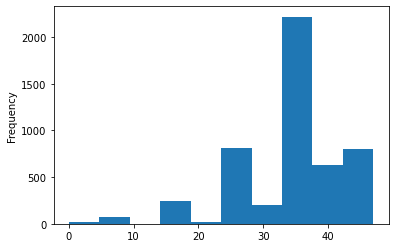

In [148]:
prediction_df.prefix_length.plot.hist()

<AxesSubplot:xlabel='num_prefix_sentences', ylabel='prediction_0'>

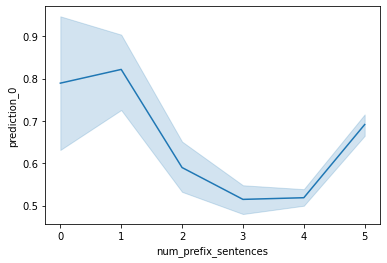

In [149]:
prediction_df["num_prefix_sentences"] = prediction_df.used_conditions.str.count(" ").fillna(0)
sns.lineplot(data=prediction_df, x="num_prefix_sentences", y="prediction_0")

## Margins

In [150]:
region_dfs = [pd.read_csv(f"{suite}.regions.csv") for suite in suites]
region_df = pd.concat(region_dfs, names=["suite"], keys=suites)
region_df

item_number      value        condition  region_number
suite                                                                    
number_src 0                 1  12.441166       match_sing              2
           1                 2  14.024705       match_sing              2
           2                 3  13.151198       match_sing              2
           3                 4  15.575526       match_sing              2
           4                 5  13.095509       match_sing              2
...                        ...        ...              ...            ...
           180499         8580   0.400255  mismatch_plural              9
           180500         8581   0.324190  mismatch_plural              9
           180501         8582   0.475358  mismatch_plural              9
           180502         8583   0.487269  mismatch_plural              9
           180503         8584   0.307768  mismatch_plural              9

[180504 rows x 4 columns]

In [151]:
# Bring in metadata from predictions df
region_df = pd.merge(region_df, prediction_df[["item_number", "prefix_length", "first_item"]],
                     on="item_number")
len(region_df)

180576

In [ ]:
def compute_margins(item_rows):
    item_rows = item_rows.pivot_table(values="value", index="condition", columns="region_number")
    return pd.Series({"sing": item_rows.loc["mismatch_sing", 7] - item_rows.loc["match_sing", 7],
                      "plur": item_rows.loc["mismatch_plural", 7] - item_rows.loc["match_plural", 7]})
    # return pd.Series({"sing": item_rows.loc[("mismatch_sing", 7)] - item_rows.loc[("match_sing", 7)],
    #                   "plur": item_rows.loc[("mismatch_plural", 7)] - item_rows.loc[("match_plural", 7)]})

margin_sizes = region_df.groupby("item_number").apply(compute_margins)

In [ ]:
margin_sizes = pd.merge(margin_sizes, prediction_df[["item_number", "prefix_length", "first_item"]],
                        on="item_number")
margin_sizes

In [ ]:
sns.lineplot(data=margin_sizes.melt(id_vars=["prefix_length"], value_vars=["sing", "plur"]),
             x="prefix_length", y="value", hue="variable")

In [ ]:
margin_sizes["prefix_length_bin"] = pd.cut(margin_sizes.prefix_length, 10).astype(str)
sns.lineplot(data=margin_sizes.melt(id_vars=["prefix_length_bin"], value_vars=["sing", "plur"]),
             x="prefix_length_bin", y="value", hue="variable")
plt.xticks(rotation=35)